In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from P02_MSIE.T01_prototype_class.DE_IM_VRPTW_classV4 import VRPTW

In [2]:
class AIMH_ENV(gym.Env):
    def __init__(self, vrp):
        super().__init__()
        self.action_space = spaces.Box(
            low = np.array([0, 0, 0], dtype=np.float32), 
            high= np.array([5, 5, 1], dtype=np.float32), 
            shape=(3,),
            dtype=np.float32,
        )
            # order = [
        #     "best_solution",
        #     "F",
        #     "CR",
        #     "MG",
        #     "percent_convergence",
        #     "std_pop",
        #     "count_total_iteration",
        # ]
        self.observation_space = gym.spaces.Box(
            low=np.array([-2, 0, 0, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([2, 10, 10, 1, 1, 1, 1e5], dtype=np.float32),
            shape=(7,),  # 7 features
            dtype=np.float64,
        )
        self.vrp = vrp
        pass


    def _get_obs(self):
        
        state = self.vrp.get_current_state()
        obs = np.array(
            [
                np.float64(state["best_solution"]),
                np.float64(state["F"]),
                np.float64(state["CR"]),
                np.float64(state["MG"]),
                np.float64(state["percent_convergence"]),
                np.float64(state["std_pop"]),
                np.float64(state["count_total_iteration"]),
            ],
            dtype=np.float32,
        )
        
        return obs
    
    def _get_info(self):
        """Compute auxiliary information for debugging.

        Returns:
            dict: Info in addition to the observation
        """
        return self.vrp.get_info()
    

    def reset(self, seed=None, options=None):
        # np.random.seed(seed or 42)
        self.vrp.reset()
        super().reset(seed=seed)
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        self.vrp.action(action)
        self.vrp.evolve()
        reward = self.vrp.get_reward(store_checkpoint=True)
        if self.vrp.is_terminated():
            terminated = True
            truncated = True
        else:
            terminated = False
            truncated = False
        observation = self._get_obs()
        info = self._get_info()
        return observation, reward, terminated, truncated, info

    

In [3]:
AIMH_ENV(vrp=None).action_space.sample()

array([1.1302295, 1.2654325, 0.8368152], dtype=float32)

In [4]:
distance = (
    pd.read_excel(
        r"../../Source/rl_meta_test_data.xlsx", sheet_name="distance"
    )
    .fillna(9999999)
    .to_numpy()
)

df_vehicle = (
    pd.read_excel(
        r"../../Source/rl_meta_test_data.xlsx", sheet_name="vehicle"
    )
    .iloc[:, :2]
    .to_numpy(dtype=int)
)
vehicle = df_vehicle[0]

df_101 = pd.read_excel(
    r"../../Source/rl_meta_test_data.xlsx", sheet_name="customer"
).iloc[:, 3:]
demand = df_101.iloc[:, 0].to_numpy()
readyTime = df_101.iloc[:, 1].to_numpy()
dueDate = df_101.iloc[:, 2].to_numpy()
serviceTime = df_101.iloc[:, -1].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}

dimensions = len(distance) - 1 + vehicle[0]
interval_it = 100
patience = 1000
population_size = 4
bounds = np.array([[0, 1]] * dimensions)
F_rate = 0.5
CR_rate = 0.5
MG_rate = 0.5

vrptw = VRPTW(
    population_size=population_size,
    dimensions=dimensions,
    bounds=bounds,
    distance=distance,
    demand=demand,
    readyTime=readyTime,
    dueDate=dueDate,
    serviceTime=serviceTime,
    vehicle=vehicle,
    interval_it=interval_it,
    patience=patience,
)

In [5]:
# TODO: Fix the environment to pass the checks
# UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
#   logger.warn(f"{pre} is not within the observation space.")
# Environment has issues: Deterministic step observations are not equivalent for the same seed and action


from gymnasium.utils.env_checker import check_env

env = AIMH_ENV(vrp=vrptw)

# This will catch many common issues
try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment has issues: The first element returned by `env.reset()` is not within the observation space.


c:\Users\admin\Coding\research\rl-meta-test\.venv\Lib\site-packages\gymnasium\utils\env_checker.py:333: UserWarning: WARN: For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.
  logger.warn(


In [6]:
from stable_baselines3 import SAC

model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [7]:
import pandas as pd

obs, info = env.reset()
terminated = False
truncated = False

data_array = []
while not (terminated or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    data_added = {**info, "reward": reward, "action": action}
    data_array.append(data_added)

df = pd.DataFrame.from_dict(data_array)
display(df)

,F,CR,MG,best_solution,percent_convergence,std_pop,count_total_iteration,rw_benchmark_solution,count_it,patience_remaining,reward,action
0,0.887923,0.010571,0.094488,60.560430,59.954826,3.074496,100,"[60.56043018565528, 60.56043018565528, 59.8688...",100,900,0.000000,"[0.88792294, 0.010571182, 0.09448844]"
1,1.000000,0.006234,0.000005,59.868817,59.961742,0.708753,200,"[60.56043018565528, 60.56043018565528, 59.8688...",200,1000,0.691613,"[4.991797, 0.006234497, 4.5597553e-06]"
2,1.000000,0.031744,0.000000,54.507363,59.323744,2.065756,300,"[60.56043018565528, 60.56043018565528, 59.8688...",300,1000,5.361454,"[4.999804, 0.031743646, 0.0]"
3,1.000000,0.006049,0.000000,54.507363,53.962289,2.065756,400,"[60.56043018565528, 60.56043018565528, 59.8688...",400,900,0.000000,"[4.999998, 0.0060485303, 0.0]"
4,1.000000,0.000158,0.000000,54.507363,53.962289,2.065756,500,"[60.56043018565528, 60.56043018565528, 59.8688...",500,800,0.000000,"[5.0, 0.00015839934, 0.0]"
5,1.000000,0.000010,0.000000,54.507363,53.962289,2.065756,600,"[60.56043018565528, 60.56043018565528, 59.8688...",600,700,0.000000,"[5.0, 6.109476e-06, 0.0]"
6,1.000000,0.000010,0.000000,54.507363,53.962289,2.065756,700,"[60.56043018565528, 60.56043018565528, 59.8688...",700,600,0.000000,"[5.0, 2.9802322e-07, 0.0]"
7,1.000000,0.000010,0.000000,54.507363,53.962289,2.065756,800,"[60.56043018565528, 60.56043018565528, 59.8688...",800,500,0.000000,"[5.0, 0.0, 0.0]"
8,1.000000,0.000010,0.000000,54.507363,53.962289,2.065756,900,"[60.56043018565528, 60.56043018565528, 59.8688...",900,400,0.000000,"[5.0, 0.0, 0.0]"
9,1.000000,0.000010,0.000000,54.507363,53.962289,2.065756,1000,"[60.56043018565528, 60.56043018565528, 59.8688...",1000,300,0.000000,"[5.0, 0.0, 0.0]"


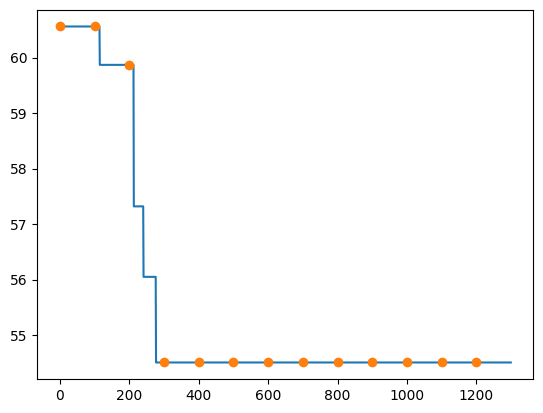

In [ ]:
import matplotlib.pyplot as plt
plt.plot(env.vrp.global_solution_history)
x = np.arange(0,len(env.vrp.global_solution_history), interval_it)
y = np.array(env.vrp.global_solution_history)[x]
plt.plot(x, y, marker='o', linestyle='')


In [18]:
x

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200])

In [17]:
vrptw.rw_benchmark_solution

[60.56043018565528,
 60.56043018565528,
 59.86881713354445,
 54.50736311718823,
 54.50736311718823,
 54.50736311718823,
 54.50736311718823,
 54.50736311718823,
 54.50736311718823,
 54.50736311718823,
 54.50736311718823,
 54.50736311718823,
 54.50736311718823,
 54.50736311718823]